## Transmission of sound from source to hydrophones

In [2]:
import h5py
import numpy as np
from scipy import signal
import scipy.interpolate as spint
import scipy.signal as spsig
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import matplotlib.ticker as tik
from pathlib import Path

In [3]:
PubDataDir = Path('../../PubData')

In [4]:
# load some parameters form the situation file: 
# * position of the interrogator
# * lake level
# * bathymetry data of lake zurich 
# * fiber geometry

path = PubDataDir / 'Situation.h5'
with h5py.File(path, "r") as f:
    x0 = f.attrs['X interrogator']
    y0 = f.attrs['Y interrogator']
    lake_level = f.attrs['Lake level (MASL)']

    sound_speed = f.attrs['Speed of sound (m/s)'] 
    print(f'sound_speed = {sound_speed:.3f} m/s')

    xmin = f['Bathymetry'].attrs['X min']
    xmax = f['Bathymetry'].attrs['X max']
    ymin = f['Bathymetry'].attrs['Y min']
    ymax = f['Bathymetry'].attrs['Y max']
    xvec = f['Bathymetry'].attrs['X data coordinates']
    yvec = f['Bathymetry'].attrs['Y data coordinates']
    xgrid,ygrid = np.meshgrid(xvec,yvec, indexing='ij')
    lake_depth = np.array(f['Bathymetry'])
    lake_depth = np.ma.array(lake_depth, mask=lake_depth==0)
    lake_depth_ip = spint.RectBivariateSpline(xvec, yvec, lake_depth)

    # track of fiber: interpolated between deploy and retrieve tracks
    interp_x = f['Tracks']['Interpolated'][:,1]
    interp_y = f['Tracks']['Interpolated'][:,2]

    # track of boat for test signal playbacks
    tr27m_x = f['Tracks']['2022-01-27 Morning'][:,1]
    tr27m_y = f['Tracks']['2022-01-27 Morning'][:,2]

# list of names
Stations = ['A','B','C','Source']
Receivers = ['A','B','C']
# colors of stations
Clr = dict(zip(Stations, ['b','r','g','y']))

sound_speed = 1425.450 m/s


In [6]:
# load the data of one shot
ShotNr = 13

path = PubDataDir / '2022-01-27--4m'
files = sorted(list(path.glob("*.h5")))
file = files[ShotNr] 
with h5py.File(file, "r") as f:
    Pos = {} # 3d positions of stations
    Sig = {} # the signal of the tetra-top hydrophone
    Dist = {} # distances from source to receiver
    s = 'Source'
    Pos[s] = np.array([f[s].attrs['Position X (m)'], f[s].attrs['Position Y (m)'], -f[s].attrs['Source Depth (m)']])
    Sig[s] = f[s][:] 
    fs = f[s].attrs['Sample Rate (Hz)']
    dt = 1/fs
    duration = f[s].attrs['Duration (s)']
    tstsq_time = np.linspace(0, duration, int(duration * fs), endpoint=False) # 25 sec long testsequence
    
    for i,r in enumerate(Receivers):
        Pos[r] = np.array([f['Recorder-'+r].attrs['Position X (m)'], f['Recorder-'+r].attrs['Position Y (m)'], -f['Recorder-'+r].attrs['Array Depth (m)']])
        Sig[r] = f['Recorder-'+r][:,0] # Tetra_top
        Dist[r] = np.linalg.norm(Pos[s] - Pos[r])               

In [7]:
# delay of AD - DA conversion
converter_delay = 1.388e-3 # DA - AD rount trip latency 
conv_delay = int(converter_delay * fs) # in samples

In [8]:
# impulse responses
irf_length = 20000 # length of the IRF: 0.4s, ca 570 m
irf_time = np.arange(0, irf_length*dt, dt)
tm = [0.0, 0.0, 0.0] # time delays of first arrival
# timeinterval 2-3s: 100000 - 150000 : noise of middle amplitude 
source = Sig['Source'][100000:150000] # source signal
E_source = dt * (source**2).sum() # energy of source signal
print(f'energy of source: {E_source:.1f} Pa^2 * s')

energy of source: 1444.2 Pa^2 * s


A
energy of hyd A: 0.592698339529451
energy ratio A: -33.86798056634496
gain of irfA: -36.30724683349908
distance: 103.3
propagation gain: -40.3
C
energy of hyd C: 0.2347341486599789
energy ratio C: -37.8905549268254
gain of irfC: -40.3378490302775
distance: 166.8
propagation gain: -44.4
B
energy of hyd B: 0.2044457590085788
energy ratio B: -38.490536611342954
gain of irfB: -40.45154258581738
distance: 206.7
propagation gain: -46.3


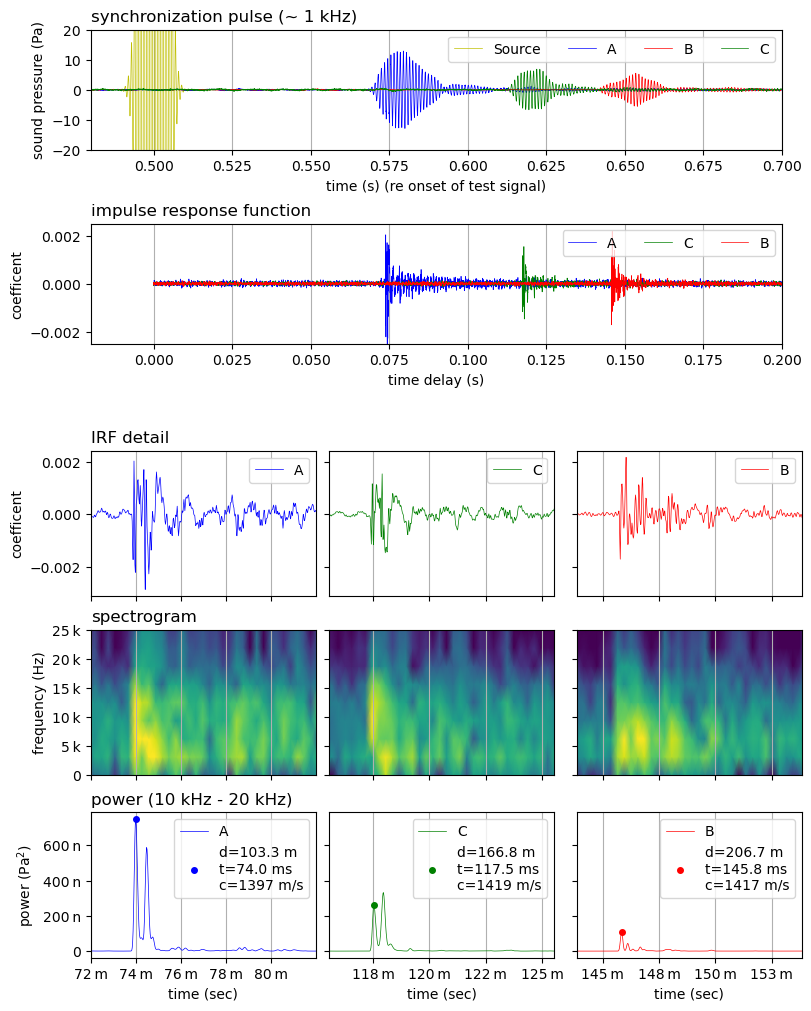

In [10]:
fig = plt.figure(layout="constrained", figsize=(8,10))
subfigs = fig.subfigures(2, 1, hspace=0.07, height_ratios=[2, 3])
axsync, axirf = subfigs[0].subplots(2, 1)

# plot arrival of the first synchronization pulse 
for i,s in enumerate(['Source','A','B','C']):
    axsync.plot(tstsq_time, Sig[s], color=Clr[s], label=s, linewidth=0.5)
axsync.legend(loc='upper right', ncols=4)
axsync.set_xlabel('time (s) (re onset of test signal)')
axsync.set_ylabel('sound pressure (Pa)')
axsync.set_title('synchronization pulse (~ 1 kHz)', loc='left')
axsync.set_xlim(0.48, 0.7) 
axsync.set_ylim(-20,20)
axsync.grid(axis='x')

# prepare irf axis 
axirf.set_xlabel('time delay (s)')
axirf.set_ylabel('coefficent')
axirf.set_title('impulse response function', loc='left')
axirf.set_xlim(-0.02,0.2) # irf_length*dt)
axirf.set_ylim(-0.0025,0.0025)
axirf.grid(axis='x')

axs = subfigs[1].subplots(3,3, sharex='col', sharey='row')

for i,r in enumerate(['A','C','B']):
    print(r)
    
    # source and received signal
    hyd0 = Sig[r][100000+conv_delay:150000+conv_delay+irf_length-1] # received signal
    flt_a, flt_b = spsig.butter(4, [200, 18000], fs=1/dt, btype='band')
    hyd = spsig.lfilter(flt_a, flt_b, hyd0) 
    
    E_hyd = dt * (hyd**2).sum() 
    print('energy of hyd '+r+': ' + str(E_hyd))
    print('energy ratio '+r+': ' + str(10 * np.log10(E_hyd / E_source)))
    
    # compute the correlation to estimate the IRF
    cor = spsig.correlate(hyd, source, mode='valid', method='direct')     
    cor = cor / E_source * dt  # normalize with the source: unit pulse  
    print('gain of irf'+r+': ' + str(10*np.log10((cor**2).sum())))
    
    print(f'distance: {Dist[r]:.1f}')
    print(f'propagation gain: {10*np.log10(1/Dist[r]**2):.1f}')
    
    #irf plot
    axirf.plot(irf_time, cor, color = Clr[r], linewidth=0.5, label=r)
    axirf.legend(loc='upper right', ncols=3)
    ax = axs[0,i]
    ax.plot(irf_time, cor, color = Clr[r], linewidth=0.5, label=r)
    ax.grid(True, axis='x')
    ax.legend()
    if i==0:
        ax.set_ylabel('coefficent')
    if i==0:
        ax.set_title('IRF detail', loc='left')
   
    # spectrogram
    (f, t, spectr) = spsig.spectrogram(cor, fs, window=('gaussian',4),
                                   nperseg=16, noverlap=1)
    ax = axs[1,i]
    pcm = ax.pcolormesh(t, f, 10*np.log10(spectr), 
                    shading='gouraud', cmap='viridis',vmin=-160, vmax=-100)
    ax.xaxis.set_major_formatter(tik.EngFormatter(places=0, sep="\N{THIN SPACE}"))
    ax.yaxis.set_major_formatter(tik.EngFormatter(places=0, sep="\N{THIN SPACE}")) 
    ax.grid(True, axis='x')
    if i==0:
        ax.set_ylabel('frequency (Hz)')
    if i==0:
        ax.set_title('spectrogram', loc='left')
    #if i==2:
    #    cbar = fig.colorbar(pcm,ax=ax)
    #    cbar.set_label('PSD (dB re 1 Pa$^2$/Hz)');

    # compute impulse response power 
    flt_a, flt_b = spsig.butter(4, [10000, 20000], fs=1/dt, btype='band')
    hyd = spsig.lfilter(flt_a, flt_b, hyd0) 
    cor = spsig.correlate(hyd, source, mode='valid', method='direct')     
    cor = cor / E_source * dt  # normalize with the source: unit pulse 
    window = spsig.windows.hann(11) # smothing a little 
    window = window / window.sum() # normalize
    p_cor = spsig.convolve(cor**2, window, mode='same', method='direct')
    p_max = p_cor.max()
    peaks, peakpar = spsig.find_peaks(p_cor, distance=9, height=p_max/20, prominence=p_max/10)
    peaks_i = np.argsort( peakpar['peak_heights'])[-3:]
    peak_first = peaks[peaks_i].min()
    first_time = irf_time[peak_first]   
    axs[1,i].set_xlim(first_time-0.002,first_time+0.008)

    # plot ir power
    ax = axs[2,i]
    ax.plot(irf_time, p_cor, color = Clr[r], linewidth=0.5, label=r)
    d = Dist[r]
    t = first_time #- converter_delay
    c = d/t
    ax.plot(first_time, p_cor[peak_first], 'o', markersize=4, color=Clr[r], label=f'd={d:.1f} m\nt={t*1000:.1f} ms\nc={c:.0f} m/s')
    ax.set_xlabel('time (sec)')
    ax.yaxis.set_major_formatter(tik.EngFormatter(places=0, sep="\N{THIN SPACE}")) 
    ax.grid(True, axis='x')
    if i==0:
        ax.set_ylabel('power (Pa$^2$)')
    if i==0:
        ax.set_title('power (10 kHz - 20 kHz)', loc='left')
    ax.legend(prop={'size': 10})              
    